# Managing Clustered Networks

This tutorial will cover the common issue of a network that is "clustered", meaning that some pores are not connected the main body of the network. This causes problems for the numerical solvers because it leads to "ill conditioned" matrices. We will explain what this means, and how to fix it

In [1]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt

In [14]:
pn = op.network.Demo(shape=[5, 5 ,1])

Now that we've created a network, lets `trim` some throats to create clusters of isolated pores:

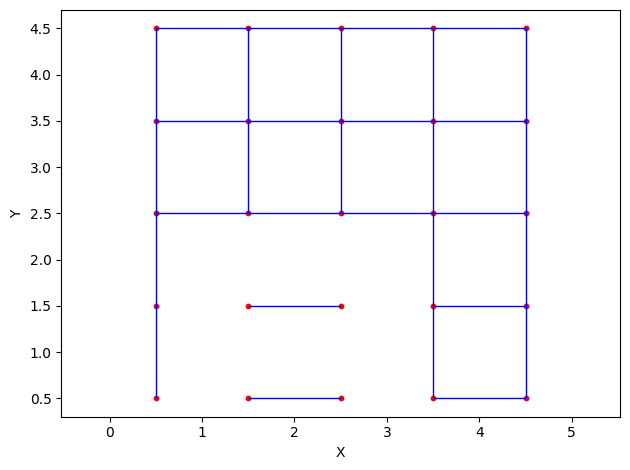

In [15]:
op.topotools.trim(network=pn, throats=[4, 5, 8, 9, 20, 21, 30, 31])
ax = op.visualization.plot_connections(pn)
op.visualization.plot_coordinates(pn, ax=ax);

Now we can have 3 total "clusters", two small clusters at the bottom plus one large cluster which constitutes the rest of the network. This is easy to see by eye, but we need to tell OpenPNM to find them so we can begin to fix the problem. In version 3 we added many new pore-scale models to the ``models.network`` libary, among them are `cluster_number` and `cluster_size`.  Let's add these two models to the network and see what we get:

In [16]:
pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Demo at 0x23cae22bc70>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                       25 / 25
  3  throat.conns                                                      32 / 32
  4  pore.coordination_number                                          25 / 25
  5  pore.max_size                                                     25 / 25
  6  throat.spacing                                                    32 / 32
  7  pore.seed                                                         25 / 25
  8  pore.diameter                                                     25 / 25
  9  throat.max_size                                                   32 / 32
 10  

We can see that cluster number and size have been added to the list of properties.  Let's inspect them:

In [17]:
pn['pore.cluster_number']

array([0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

We can see that most pores a labeled 0, meaning they belong to cluster 0. However, there are a few with cluster numbers of 1 and  2, which we know correspond to the two small clusters in our network.  We *could* solve our current problem by trimming these pores, but let's do it the proper way. Had we not looked at the network visualization, We would not actually know that cluster 0 is the *main* cluster.  We can look at the *size* of each cluster instead:

In [19]:
pn['pore.cluster_size']

array([21., 21., 21., 21., 21.,  2.,  2., 21., 21., 21.,  2.,  2., 21.,
       21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.])

Now we can see that most pores belong to a large cluster of size 21, where there are a few on small clusters. Now we can clearly tell which pores should be trimmed:

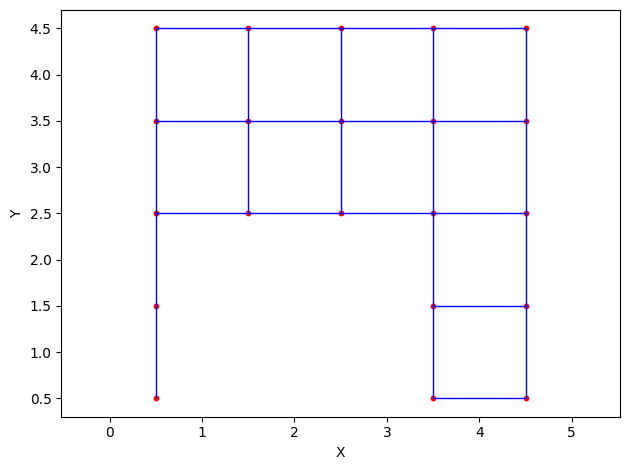

In [22]:
Ps = pn['pore.cluster_size'] < 21
op.topotools.trim(network=pn, pores=Ps)
ax = op.visualization.plot_connections(pn)
op.visualization.plot_coordinates(pn, ax=ax);

Now we can see only a single cluster.  Without even re-running the pore-scale models we can see that the pores with a cluster number other than 0 have been removed:

In [23]:
pn['pore.cluster_number']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])